In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [1]:
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

def balance(X_temp, y_temp):
  smote = SMOTE()
  X_temp, y_temp= smote.fit_resample(X_temp, y_temp)
  return pd.concat([pd.DataFrame(X_temp), pd.DataFrame(y_temp)], axis=1)

In [2]:
from joblib import Parallel, delayed
import joblib
  

def save_model(model,model_name):
 joblib.dump(model, model_name)
  
def load_model(model_name):
  return joblib.load(model_name)

In [3]:
#!pip install shap
import shap
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import cross_val_score

def SHAP_EXP(model,X_test,features_names):
  graph_feat={
    "max_display":20,
    "shap_values Index":2
  }

  print("Model: ",model)

  explainer = shap.Explainer(model.predict, X_test)

  shap_values1 = explainer(X_test)

  if 'Subjects' in features_names:
    features_names.pop(0)


  shap.plots.bar(shap_values1,max_display=graph_feat["max_display"])

  print("---------------------")

  shap.summary_plot(shap_values1,max_display=graph_feat["max_display"],feature_names=features_names)

  print("---------------------")

  print("Local Explaination")
  shap.plots.waterfall(shap_values1[graph_feat["shap_values Index"]],max_display=graph_feat["max_display"])


  print("---------------------")

  shap.plots.bar(shap_values1[graph_feat["shap_values Index"]],max_display=graph_feat["max_display"])
    
    




# LIME

In [4]:
import lime
from lime import lime_tabular
from IPython.display import HTML


def explain_lime(model,rw_number,name_of,num_features=6,top_labels=5):
    explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=list(dataset.iloc[:0,1:]),
    class_names=['N1','N2','N3','R','W'],
    mode='classification'
    )

    exp = explainer.explain_instance(X_test.iloc[rw_number],
                                model.predict_proba,
                                num_features=num_features,
                                top_labels=top_labels)

    exp.show_in_notebook(show_table=True, show_all=True)

    html_data = exp.as_html()
    HTML(data=html_data)

    exp.save_to_file(name_of+"LIME_explanation.html")

# Confusion

In [5]:
def confusion_details(y_test,y_pred):
    labels = list(set(y_test))
    labels.sort()

    print("Total labels: %s -> %s" % (len(labels), labels))

    df = pd.DataFrame(
        data=confusion_matrix(y_test, y_pred, labels=labels),
        columns=labels,
        index=labels
    )

    print(df)

    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Local (metrics per class)
    #
    tps = {}
    fps = {}
    fns = {}
    tns = {}

    precision_local = {}
    recall_local = {}
    f1_local = {}
    accuracy_local = {}
    specificity_local={}

    for label in labels:
        tps[label] = df.loc[label, label]
        fps[label] = df[label].sum() - tps[label]
        fns[label] = df.loc[label].sum() - tps[label]
        tns[label]=len(y_test) - (tps[label] + fps[label] + fns[label])
        
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        
        precision_local[label] = tp / (tp + fp) if (tp + fp) > 0. else 0.
        specificity_local[label] = tn / (tn + fp) if (tn + fp) > 0. else 0.
        recall_local[label] = tp / (tp + fn) if (tp + fp) > 0. else 0.
        p, r = precision_local[label], recall_local[label]
        
        f1_local[label] = 2. * p * r / (p + r) if (p + r) > 0. else 0.
        accuracy_local[label] = tp / (tp + fp + fn) if (tp + fp + fn) > 0. else 0.



    print("#-- Local measures --#")
    print("True Positives(TP):", tps)
    print("False Positives(FP):", fps)
    print("True Negatives(TN):", tns)
    print("False Negatives(FN):", fns)
    print("----------------------------")

    print("Precision:", precision_local)
    print("Recall/Sensitivity:", recall_local)
    print("Specificity:",specificity_local)
    print("F1-Score:", f1_local)
    print("Accuracy:", accuracy_local)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Global
    #
    micro_averages = {}
    macro_averages = {}

    correct_predictions = sum(tps.values())
    true_negative=sum(tns.values())

    den = sum(list(tps.values()) + list(fps.values()))
    micro_averages["Precision"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tps.values()) + list(fns.values()))
    micro_averages["Recall"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tns.values()) + list(fps.values()))
    micro_averages["Specificity"] = 1. * true_negative / den if den > 0. else 0.


    micro_avg_p, micro_avg_r = micro_averages["Precision"], micro_averages["Recall"]
    micro_averages["F1-score"] = 2. * micro_avg_p * micro_avg_r / (micro_avg_p + micro_avg_r) if (micro_avg_p + micro_avg_r) > 0. else 0.

    macro_averages["Precision"] = np.mean(list(precision_local.values()))
    macro_averages["Recall"] = np.mean(list(recall_local.values()))
    macro_averages["Specificity"]=np.mean(list(specificity_local.values()))


    macro_avg_p, macro_avg_r = macro_averages["Precision"], macro_averages["Recall"]
    macro_averages["F1-Score"] = 2. * macro_avg_p * macro_avg_r / (macro_avg_p + macro_avg_r) if (macro_avg_p + macro_avg_r) > 0. else 0.

    total_predictions = df.values.sum()
    accuracy_global = correct_predictions / total_predictions if total_predictions > 0. else 0.

    print("#-- Global measures --#")
    print("Micro-Averages:", micro_averages)
    print("Macro-Averages:", macro_averages)
    print("Correct predictions:", correct_predictions)
    print("Total predictions:", total_predictions)
    print("Accuracy:", accuracy_global)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()



    accuracy_local_new = {}
    for label in labels:
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        accuracy_local_new[label] = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0. else 0.

    total_true = sum(list(tps.values()) + list(tns.values()))
    total_predictions = sum(list(tps.values()) + list(tns.values()) + list(fps.values()) + list(fns.values()))
    accuracy_global_new = 1. * total_true / total_predictions if total_predictions > 0. else 0.

    print("Accuracy (per class), with TNs:", accuracy_local_new)
    print("Accuracy (per class), without TNs:", accuracy_local)
    print("Accuracy (global), with TNs:", accuracy_global_new)
    print("Accuracy (global), without TNs:", accuracy_global)

In [6]:
#!pip install seaborn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def Con_Mat(y_test,y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize = (15,10))
  sn.heatmap(cm, annot=True, fmt='d',linewidth=.5) # here, cm is called to be visualized
  plt.xlabel('Predicted',fontsize=14.0, fontweight='bold')
  plt.ylabel('Truth',fontsize=12.0, fontweight='bold')

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def Accurecy_Details(y_test,y_pred):    
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test,y_pred))
  print("Accurecy: ",accuracy_score(y_test, y_pred))

# ROC

In [ ]:
!pip install plotly==5.11.0

In [ ]:
!pip install -U kaleido

In [41]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

def ploty_ROC(model,X,y,fig_name):
    
    lebel_dict={
    0: "N1",
    1: "N2",
    2: "N3",
    3: "R",
    4: "W"
    }

    y_scores = model.predict_proba(X)

    y_onehot = pd.get_dummies(y, columns=model.classes_)

    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)
        name = f"{lebel_dict[y_onehot.columns[i]]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=1000, height=1000,
        font=dict(
            family="Courier New, monospace",
            size=20,
            color="BLack"
        ),
        legend=dict(
            x=0.67,
            y=0.05,
            traceorder="reversed",
            title_font_family="Times New Roman",
            font=dict(
                family="Courier New, monospace",
                size=20,
                color="black"
            ),
            bgcolor="LightSteelBlue",
            bordercolor="White",
            borderwidth=2
        )
    )
    fig.show()
    fig.write_image(fig_name+".png")


# Main Code

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm

dataset=pd.read_csv("EEG_Five_Stages_HMC.csv")


target="Sleep_Stage"

classes = np.array(sorted(list(set(dataset[target]))))

features = list(dataset.iloc[:0,1:])

In [13]:
dataset.head()

,Sleep_Stage,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,...,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
0,4,0.00051,8.74146,18.48195,17.48293,8.24195,0.00071,19.73073,29.84585,33.84195,...,0.00724,0.74927,3.87122,1.99805,0.87415,0.000210,35.21561,42.20878,49.95122,49.95122
1,4,0.00040,10.24000,17.48293,16.85854,10.61463,0.00051,17.23317,26.34927,29.34634,...,0.00723,0.49951,3.74634,1.24878,0.49951,0.000095,34.34146,43.33268,49.95122,49.95122
2,4,0.00036,9.74049,17.98244,17.48293,8.74146,0.00047,17.60780,25.47512,28.22244,...,0.00230,0.62439,5.24488,2.12293,0.62439,0.000074,34.59122,45.95512,49.95122,49.95122
3,4,0.00035,10.11512,17.60780,17.10829,9.61561,0.00047,17.35805,26.47415,28.72195,...,0.00091,0.87415,6.61854,3.12195,0.62439,0.000082,32.46829,43.95707,49.95122,49.95122
4,4,0.00033,9.74049,17.60780,17.23317,8.11707,0.00043,17.23317,25.84976,28.09756,...,0.00175,0.49951,5.74439,2.24780,0.49951,0.000077,33.59220,44.83122,49.95122,49.95122


In [12]:

print("-------------------Before-------------------------")
set(list(dataset[target]))
frequency = dataset["Sleep_Stage"].value_counts()
print(frequency)


from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
dataset[target]=encoder.fit_transform(dataset[target])


print("--------------------After--------------------------")
set(list(dataset[target]))
frequency = dataset["Sleep_Stage"].value_counts()
print(frequency)

-------------------Before-------------------------
1    39428
2    21290
4    19355
3    16465
0    11913
Name: Sleep_Stage, dtype: int64
--------------------After--------------------------
1    39428
2    21290
4    19355
3    16465
0    11913
Name: Sleep_Stage, dtype: int64


In [15]:
X = dataset.loc[:, dataset.columns!=target]
y = dataset[target]



In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)


In [17]:

print("----------------------before------------------")
frequency = y_train.value_counts()
print(frequency)


new_dataset=balance(X_train,y_train)

X_train = new_dataset.loc[:, new_dataset.columns!=target]
y_train = new_dataset[target]


print("----------------------After------------------")
frequency = y_train.value_counts()
print(frequency)

----------------------before------------------
1    31537
2    17036
4    15551
3    13091
0     9545
Name: Sleep_Stage, dtype: int64
----------------------After------------------
0    31537
3    31537
2    31537
1    31537
4    31537
Name: Sleep_Stage, dtype: int64


# XGBoost

In [18]:
xg = load_model("XGBClassifier(n_estimators=8000,max_depth=14,random_state=0)")




### Testing Accuracy Details

In [19]:

y_pred=xg.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1113  536   10  247  462]
 [ 440 6662  408  243  138]
 [  70  587 3574    6   17]
 [ 192  216   14 2897   55]
 [ 310   64    3   26 3401]]
              precision    recall  f1-score   support

           0       0.52      0.47      0.50      2368
           1       0.83      0.84      0.84      7891
           2       0.89      0.84      0.87      4254
           3       0.85      0.86      0.85      3374
           4       0.84      0.89      0.86      3804

    accuracy                           0.81     21691
   macro avg       0.78      0.78      0.78     21691
weighted avg       0.81      0.81      0.81     21691

Accurecy:  0.8135632289889816


### Trainin Accuracy Deatails

In [21]:

y_pred_train=xg.predict(X_train)
Accurecy_Details(y_train, y_pred_train)

[[31092     8    20   172   245]
 [  429 31108     0     0     0]
 [  437     4 31074     1    21]
 [  634     1    16 30822    64]
 [  774     0     6     3 30754]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     31537
           1       1.00      0.99      0.99     31537
           2       1.00      0.99      0.99     31537
           3       0.99      0.98      0.99     31537
           4       0.99      0.98      0.98     31537

    accuracy                           0.98    157685
   macro avg       0.98      0.98      0.98    157685
weighted avg       0.98      0.98      0.98    157685

Accurecy:  0.9820211180518121


### Confusion For Testing

In [ ]:
confusion_details(y_test, y_pred)

In [ ]:
Con_Mat(y_test,y_pred)

### Confusion For training

In [22]:
confusion_details(y_train, y_pred_train)

Total labels: 5 -> [0, 1, 2, 3, 4]
       0      1      2      3      4
0  31092      8     20    172    245
1    429  31108      0      0      0
2    437      4  31074      1     21
3    634      1     16  30822     64
4    774      0      6      3  30754

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 31092, 1: 31108, 2: 31074, 3: 30822, 4: 30754}
False Positives(FP): {0: 2274, 1: 13, 2: 42, 3: 176, 4: 330}
True Negatives(TN): {0: 123874, 1: 126135, 2: 126106, 3: 125972, 4: 125818}
False Negatives(FN): {0: 445, 1: 429, 2: 463, 3: 715, 4: 783}
----------------------------
Precision: {0: 0.9318467901456573, 1: 0.9995822756338164, 2: 0.9986502121095256, 3: 0.9943222143364088, 4: 0.9893836057135503}
Recall/Sensitivity: {0: 0.9858895900053904, 1: 0.9863969305894663, 2: 0.9853188318483052, 3: 0.9773282176491106, 4

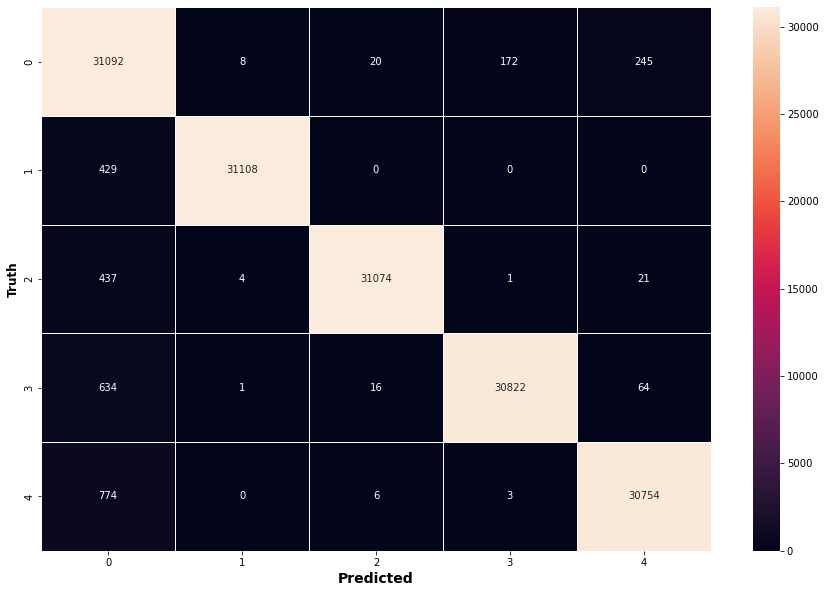

In [24]:
Con_Mat(y_train,y_pred_train)

### SHAP

In [ ]:
SHAP_EXP(xg,X_test.values[0:100],features)

### LIME

In [ ]:
print(X_test.iloc[15])

In [ ]:
explain_lime(xg,15,"XG")

### ROC TRAINING

In [42]:
ploty_ROC(xg,X_train,y_train,"XB_TRINING_ROC")

### ROC TESTING

In [43]:
ploty_ROC(xg,X_test,y_test,"XB_TESTING_ROC")

# GradientBoosting


In [28]:
gb = load_model("GradientBoostingClassifier(max_depth=14, n_estimators=4500)")


### Testing Accuracy Details 

In [ ]:

y_pred=gb.predict(X_test)
Accurecy_Details(y_test, y_pred)

### Training Accuracy Details

In [29]:

y_pred_train=gb.predict(X_train)
Accurecy_Details(y_train, y_pred_train)

[[30927    25    22   206   357]
 [  429 31108     0     0     0]
 [  460    12 31029     0    36]
 [  800    10    14 30625    88]
 [  908     2    10    10 30607]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     31537
           1       1.00      0.99      0.99     31537
           2       1.00      0.98      0.99     31537
           3       0.99      0.97      0.98     31537
           4       0.98      0.97      0.98     31537

    accuracy                           0.98    157685
   macro avg       0.98      0.98      0.98    157685
weighted avg       0.98      0.98      0.98    157685

Accurecy:  0.9785077845070869


### Confusion for testing

In [ ]:
confusion_details(y_test, y_pred)

In [ ]:
Con_Mat(y_test,y_pred)

### Confusion for treaining

In [30]:
confusion_details(y_train, y_pred_train)

Total labels: 5 -> [0, 1, 2, 3, 4]
       0      1      2      3      4
0  30927     25     22    206    357
1    429  31108      0      0      0
2    460     12  31029      0     36
3    800     10     14  30625     88
4    908      2     10     10  30607

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 30927, 1: 31108, 2: 31029, 3: 30625, 4: 30607}
False Positives(FP): {0: 2597, 1: 49, 2: 46, 3: 216, 4: 481}
True Negatives(TN): {0: 123551, 1: 126099, 2: 126102, 3: 125932, 4: 125667}
False Negatives(FN): {0: 610, 1: 429, 2: 508, 3: 912, 4: 930}
----------------------------
Precision: {0: 0.9225331106073261, 1: 0.9984273197034375, 2: 0.9985197103781175, 3: 0.9929963360461723, 4: 0.9845277920741122}
Recall/Sensitivity: {0: 0.9806576402321083, 1: 0.9863969305894663, 2: 0.9838919364555918, 3: 0.9710815867076767, 4

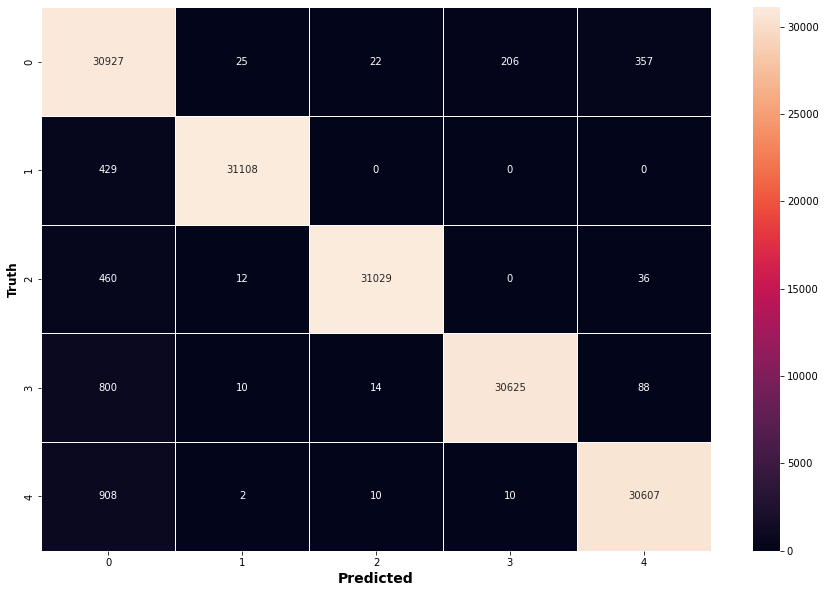

In [31]:
Con_Mat(y_train,y_pred_train)

### SHAP

In [ ]:
SHAP_EXP(gb,X_test.values[0:100],features)

### LIME

In [ ]:
explain_lime(gb,15,"GB")

### ROC TRAINING

In [44]:
ploty_ROC(gb,X_train,y_train,"GB_TRINING_ROC")

### ROC TESTING

In [45]:
ploty_ROC(gb,X_test,y_test,"GB_TESTING_ROC")

# Random Forest

In [32]:
rf = load_model("RandomForestClassifier(max_depth=49, random_state=0)")

### Accuracy Details for Testing

In [ ]:

y_pred=rf.predict(X_test)
Accurecy_Details(y_test, y_pred)

### Accuracy Details for Training

In [33]:
y_pred_train=rf.predict(X_train)
Accurecy_Details(y_train, y_pred_train)

[[29570   530    41   616   780]
 [  429 31108     0     0     0]
 [  439   220 30818     1    59]
 [  759   162    32 30405   179]
 [  933    36    13    29 30526]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     31537
           1       0.97      0.99      0.98     31537
           2       1.00      0.98      0.99     31537
           3       0.98      0.96      0.97     31537
           4       0.97      0.97      0.97     31537

    accuracy                           0.97    157685
   macro avg       0.97      0.97      0.97    157685
weighted avg       0.97      0.97      0.97    157685

Accurecy:  0.966655040111615


### Confusion for testing

In [ ]:
confusion_details(y_test, y_pred)

In [ ]:
Con_Mat(y_test,y_pred)

### Confusion for training

In [34]:
confusion_details(y_train, y_pred_train)

Total labels: 5 -> [0, 1, 2, 3, 4]
       0      1      2      3      4
0  29570    530     41    616    780
1    429  31108      0      0      0
2    439    220  30818      1     59
3    759    162     32  30405    179
4    933     36     13     29  30526

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 29570, 1: 31108, 2: 30818, 3: 30405, 4: 30526}
False Positives(FP): {0: 2560, 1: 948, 2: 86, 3: 646, 4: 1018}
True Negatives(TN): {0: 123588, 1: 125200, 2: 126062, 3: 125502, 4: 125130}
False Negatives(FN): {0: 1967, 1: 429, 2: 719, 3: 1132, 4: 1011}
----------------------------
Precision: {0: 0.9203236850295674, 1: 0.9704267531819316, 2: 0.9972171887134351, 3: 0.9791955170525909, 4: 0.9677276185645448}
Recall/Sensitivity: {0: 0.9376288169451755, 1: 0.9863969305894663, 2: 0.9772013825030916, 3: 0.96410565367663

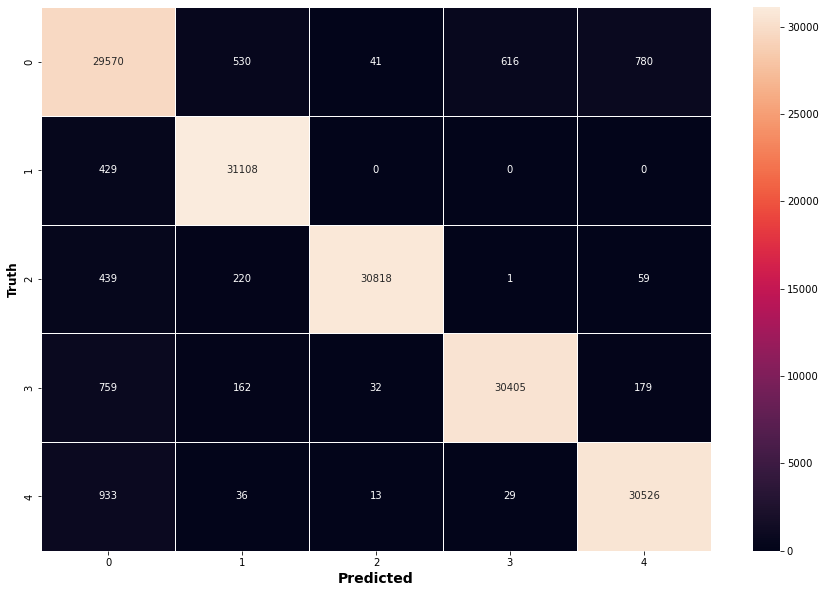

In [35]:
Con_Mat(y_train,y_pred_train)

### SHAP

In [ ]:
SHAP_EXP(rf,X_test.values[0:100],features)

### LIME

In [ ]:
explain_lime(rf,15,"RF")

### ROC TRAINING

In [46]:
ploty_ROC(rf,X_train,y_train,"RF_TRINING_ROC")

### ROC TESTING

In [47]:
ploty_ROC(rf,X_test,y_test,"RF_TESTING_ROC")